<a href="https://colab.research.google.com/github/roxacarv/edulearn/blob/main/classifica%C3%A7%C3%A3o/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregamento dos dados

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import datasets
from mlxtend.plotting import plot_decision_regions

dataset = pd.read_csv("dados_ies_novas_categorias_utf8.csv", index_col=0, encoding="latin-1")

# 1.0 Mapa de correlação entre os dados

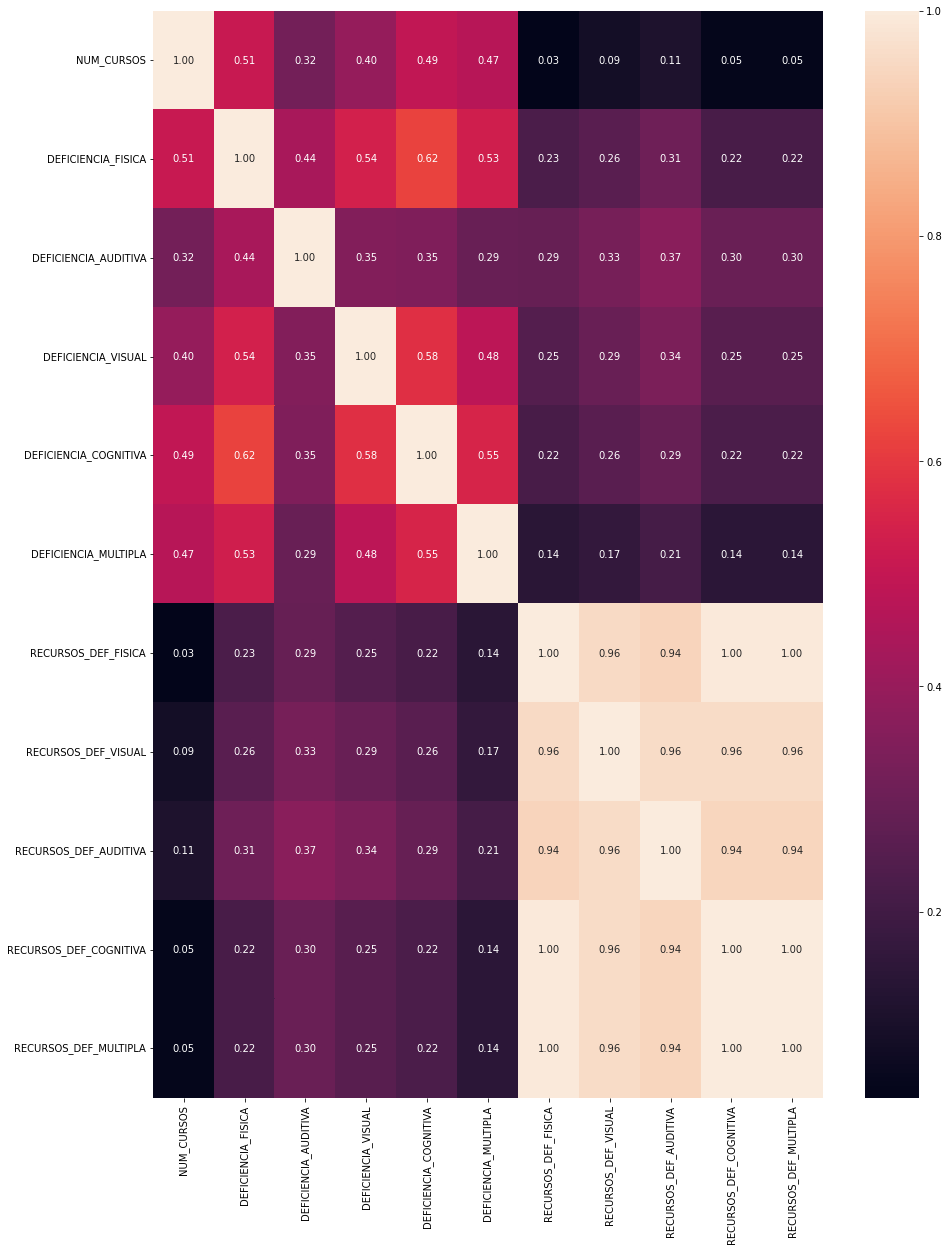

In [2]:
from pylab import rcParams

def plot_correlation(data):
    rcParams['figure.figsize'] = 15, 20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')

df = dataset.drop(columns=[
                          "REGIAO", 
                          "TIPO_CATEGORIA_ADM", 
                          "UF", 
                          "CODIGO_IES"
                          ])

plot_correlation(df)

### 1.1 Visualizando os dados de Recursos X Deficiência

#### 1.1.1 Deficiência Física X Recursos para Deficiência Física

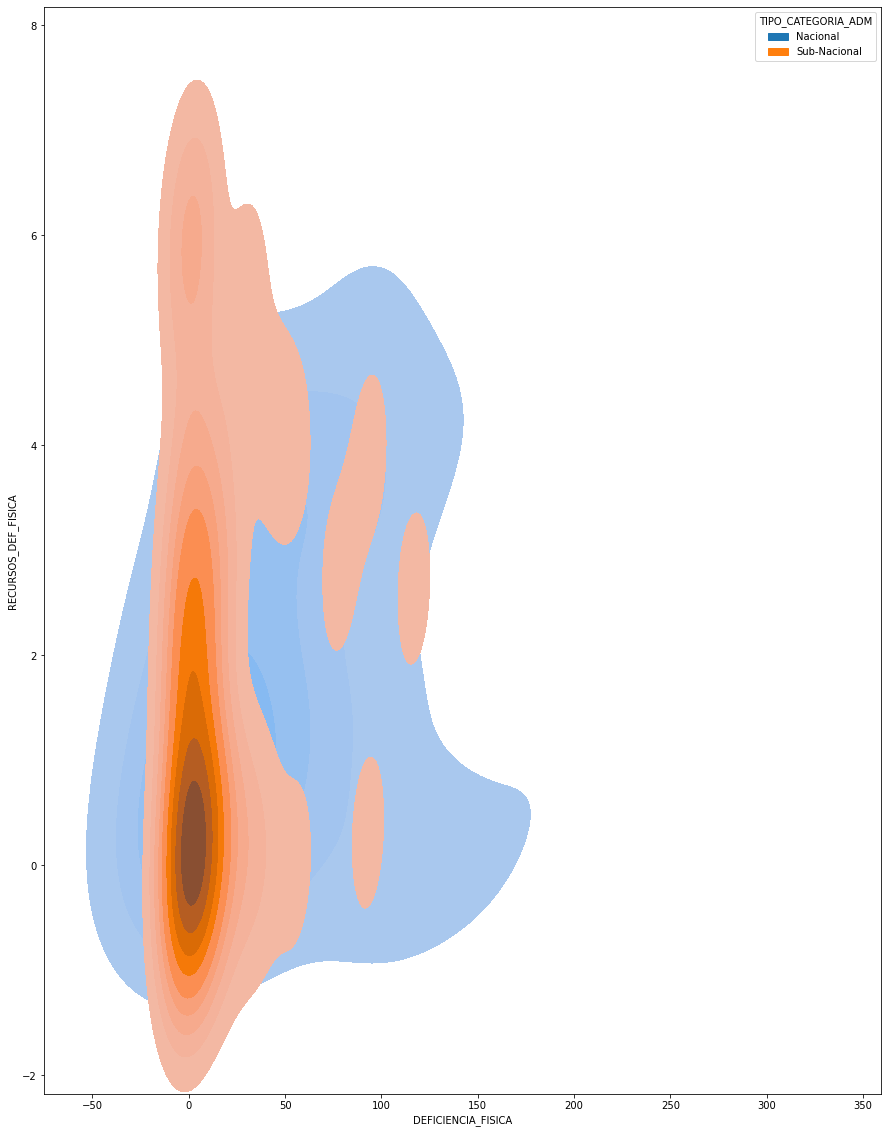

In [ ]:
sns.kdeplot(
    data=dataset, 
    x="DEFICIENCIA_FISICA",
    y="RECURSOS_DEF_FISICA", 
    hue="TIPO_CATEGORIA_ADM", 
    fill=True
)

#### 1.1.2 Deficiência Visual X Recursos para Deficiência Visual

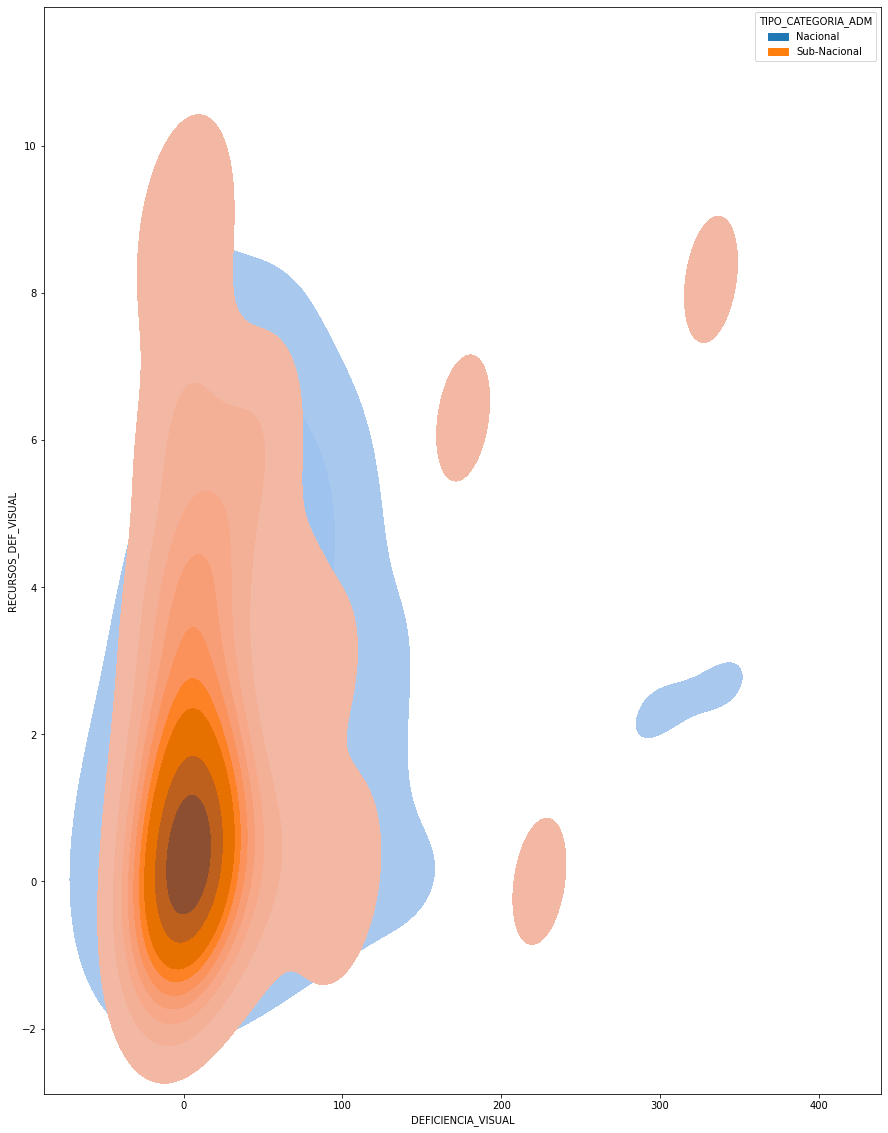

In [ ]:
sns.kdeplot(
    data=dataset, 
    x="DEFICIENCIA_VISUAL",
    y="RECURSOS_DEF_VISUAL", 
    hue="TIPO_CATEGORIA_ADM", 
    fill=True
)

#### 1.1.3 Deficiência Auditiva X Recursos para Deficiência Auditiva

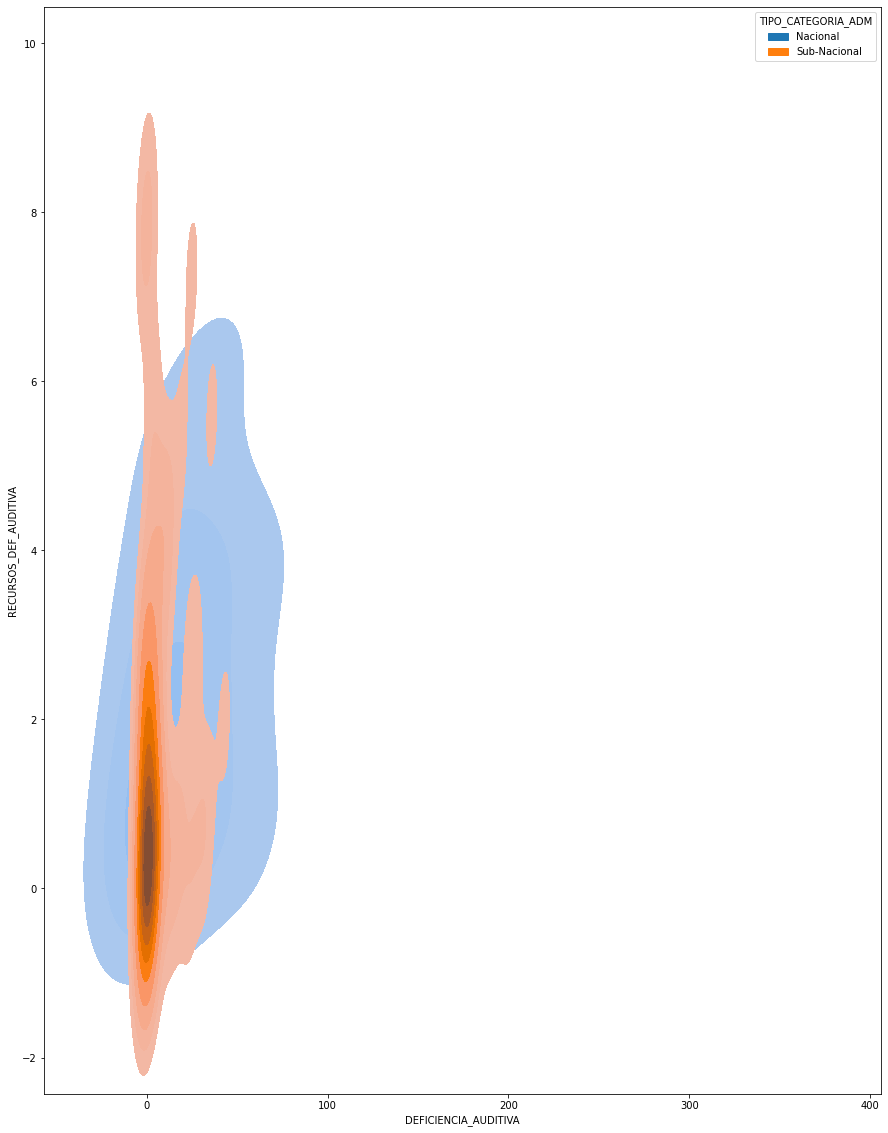

In [ ]:
sns.kdeplot(
    data=dataset, 
    x="DEFICIENCIA_AUDITIVA",
    y="RECURSOS_DEF_AUDITIVA", 
    hue="TIPO_CATEGORIA_ADM", 
    fill=True
)

#### 1.1.4 Deficiência Cognitiva X Recursos para Deficiência Cognitiva

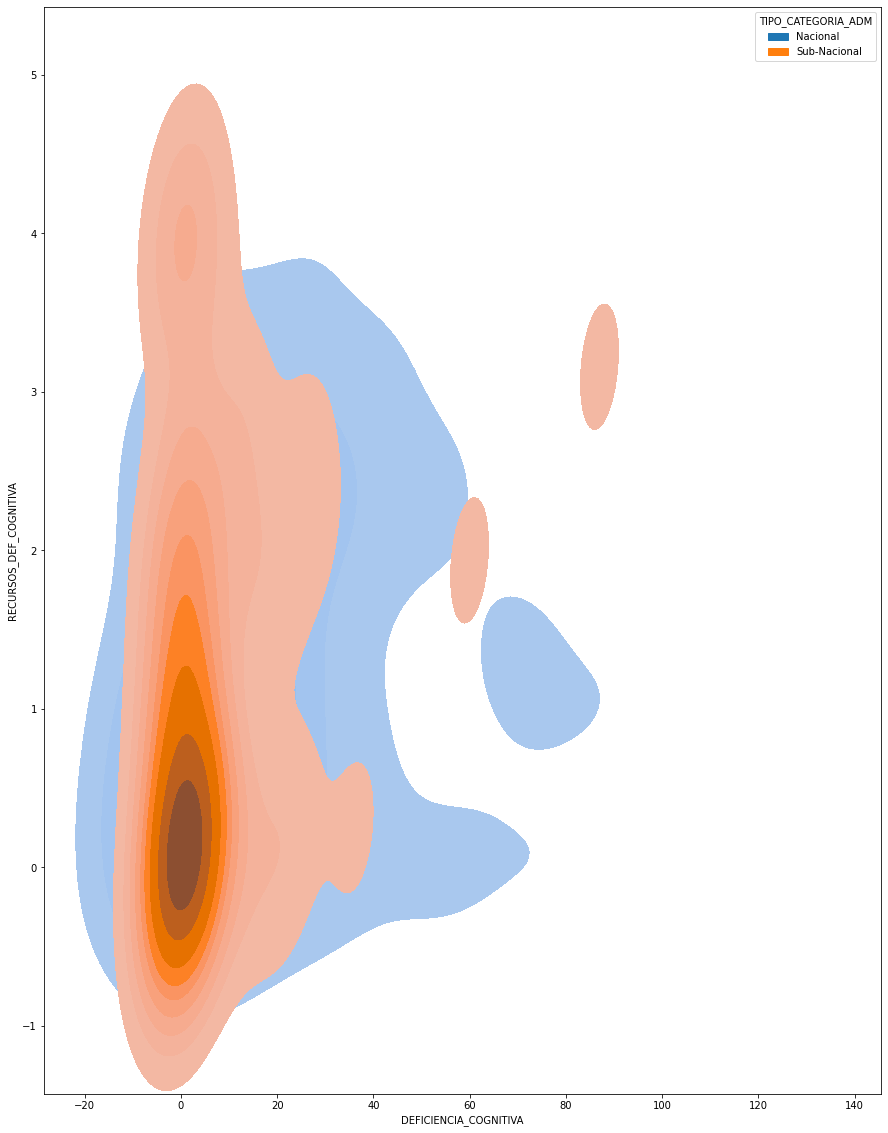

In [ ]:
sns.kdeplot(
    data=dataset, 
    x="DEFICIENCIA_COGNITIVA",
    y="RECURSOS_DEF_COGNITIVA", 
    hue="TIPO_CATEGORIA_ADM", 
    fill=True
)

#### 1.1.5 Deficiência Múltipla X Recursos para Deficiência Múltipla

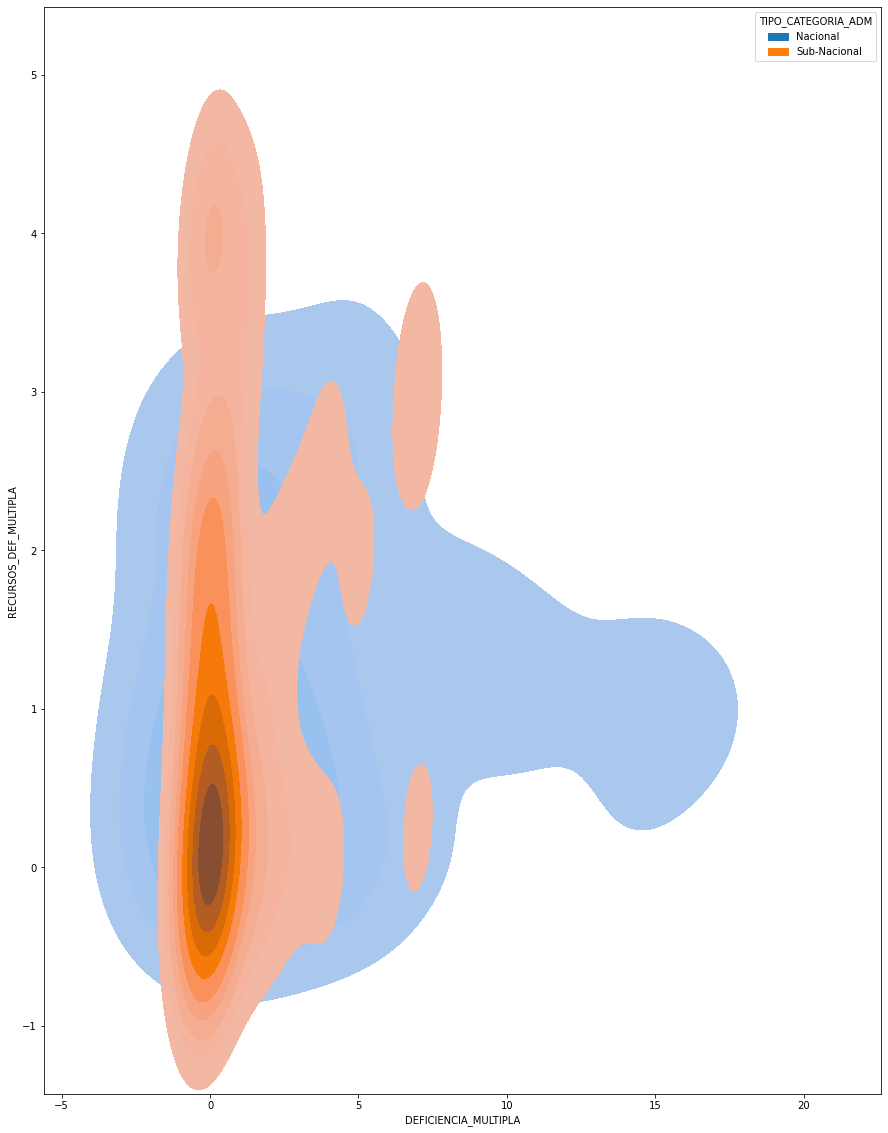

In [ ]:
sns.kdeplot(
    data=dataset, 
    x="DEFICIENCIA_MULTIPLA",
    y="RECURSOS_DEF_MULTIPLA", 
    hue="TIPO_CATEGORIA_ADM", 
    fill=True
)


# 2.0 Predição do dataset utilizando KNN

### 2.1 Separando os dados treinamento e teste


In [18]:
X = dataset.drop(columns=[ 
                          "TIPO_CATEGORIA_ADM",
                          "DEFICIENCIA_AUDITIVA",
                          "DEFICIENCIA_MULTIPLA",
                          "DEFICIENCIA_VISUAL",
                          "DEFICIENCIA_COGNITIVA",
                          "RECURSOS_DEF_VISUAL",
                          "RECURSOS_DEF_COGNITIVA",
                          "RECURSOS_DEF_AUDITIVA",
                          "RECURSOS_DEF_MULTIPLA",
                          "REGIAO",
                          "UF",
                          "NUM_CURSOS",
                          "CODIGO_IES"
                          ])
y = dataset["TIPO_CATEGORIA_ADM"].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

### 2.2 Cria o objeto KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

array(['Nacional', 'Nacional', 'Sub-Nacional', 'Sub-Nacional', 'Nacional',
       'Nacional', 'Sub-Nacional', 'Sub-Nacional', 'Sub-Nacional',
       'Nacional', 'Nacional', 'Sub-Nacional', 'Sub-Nacional',
       'Sub-Nacional', 'Sub-Nacional', 'Sub-Nacional', 'Nacional',
       'Sub-Nacional', 'Nacional', 'Nacional', 'Sub-Nacional',
       'Sub-Nacional', 'Sub-Nacional', 'Nacional', 'Sub-Nacional',
       'Nacional', 'Sub-Nacional', 'Sub-Nacional', 'Nacional',
       'Sub-Nacional', 'Nacional', 'Nacional', 'Nacional', 'Nacional',
       'Nacional', 'Nacional', 'Nacional', 'Sub-Nacional', 'Sub-Nacional',
       'Nacional', 'Sub-Nacional', 'Nacional', 'Sub-Nacional', 'Nacional',
       'Sub-Nacional', 'Nacional', 'Sub-Nacional', 'Nacional', 'Nacional',
       'Nacional', 'Sub-Nacional', 'Sub-Nacional', 'Nacional', 'Nacional',
       'Nacional', 'Nacional', 'Sub-Nacional', 'Sub-Nacional',
       'Sub-Nacional', 'Sub-Nacional', 'Nacional', 'Nacional',
       'Sub-Nacional', 'Sub-Nacional',

### 2.3 Validando a acurácia e precisão da predição dos dados

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Confusion matrix:

[[30 10]
 [10 44]]

Classification report:

              precision    recall  f1-score   support

    Nacional       0.75      0.75      0.75        40
Sub-Nacional       0.81      0.81      0.81        54

    accuracy                           0.79        94
   macro avg       0.78      0.78      0.78        94
weighted avg       0.79      0.79      0.79        94

Accuracy:  0.7872340425531915


#### 2.3.1 Medido o "score" da predição

In [13]:
knn = KNeighborsClassifier(n_neighbors=8, metric="euclidean")
k = knn.fit(X_train, y_train)
pred_i = knn.predict(X_test)
k_score = k.score(X_test, y_test)
k_score

0.7978723404255319

### 2.4 Procurando o melhor valor para K através da taxa de erro

Text(0, 0.5, 'Erro médio')

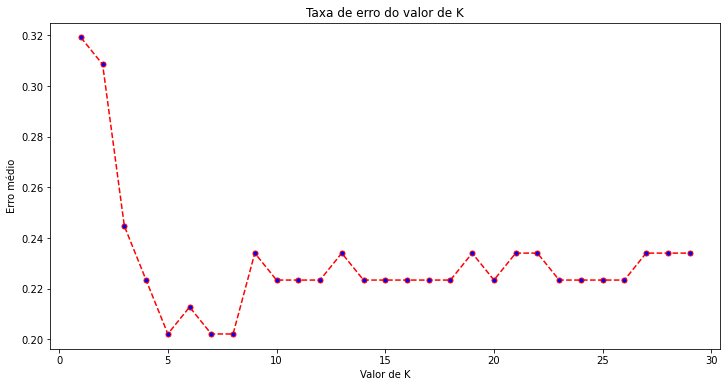

In [12]:
error = []

for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=5)
plt.title('Taxa de erro do valor de K')
plt.xlabel('Valor de K')
plt.ylabel('Erro médio')

# 3.0 Visualizando KNN

### 3.1 Visualizando regiões

[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1
 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0
 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


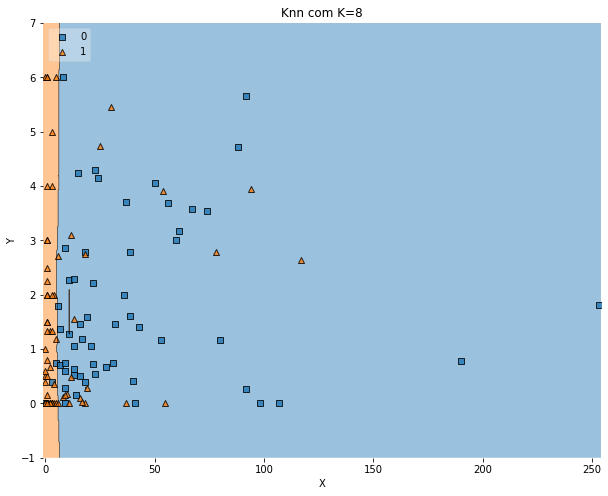

In [24]:
def knn_comparison(X, y, k):
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(X, y)
  value=1.5
  width=0.75
# Plotting decision region
  plt.figure(figsize=(10, 8))
  plot_decision_regions(
     X.to_numpy(), 
     y, 
     clf=clf,
     legend=2
     )
# Adding axes annotations
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Knn com K=" + str(k))
  plt.show()

X = dataset.drop(columns=[ 
                          "TIPO_CATEGORIA_ADM",
                          "DEFICIENCIA_AUDITIVA",
                          "DEFICIENCIA_MULTIPLA",
                          "DEFICIENCIA_VISUAL",
                          "DEFICIENCIA_COGNITIVA",
                          "RECURSOS_DEF_VISUAL",
                          "RECURSOS_DEF_COGNITIVA",
                          "RECURSOS_DEF_AUDITIVA",
                          "RECURSOS_DEF_MULTIPLA",
                          "REGIAO",
                          "UF",
                          "NUM_CURSOS",
                          "CODIGO_IES"
                          ])
y = dataset["TIPO_CATEGORIA_ADM"].values

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(dataset["TIPO_CATEGORIA_ADM"])
dataset["TIPO_CATEGORIA_ADM"]=le.transform(dataset["TIPO_CATEGORIA_ADM"])

from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.4)

for i in [8]:
  knn_comparison(X2_train, y2_train, i)

### 3.2 Visualizando um mapa de cores

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


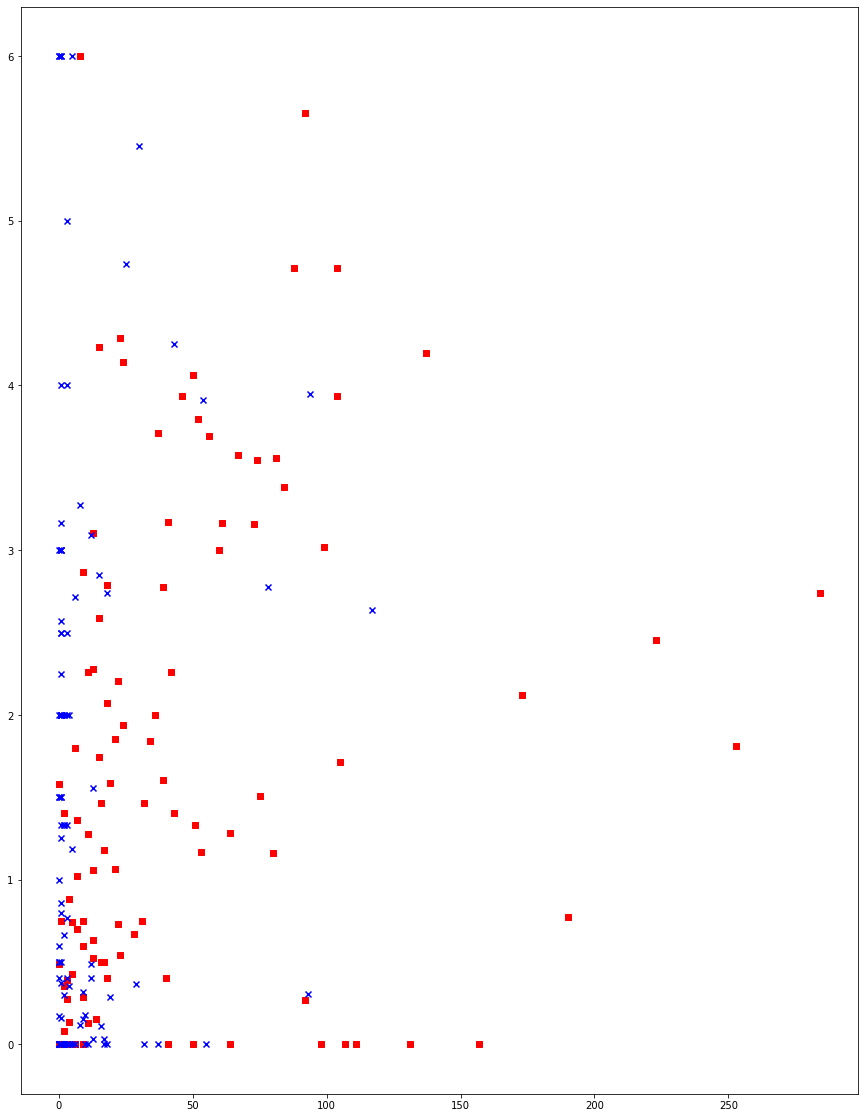

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

X = X.to_numpy()

markers = ('s', 'x', 'o')
colors = ('red', 'blue', 'lightgreen')
cmap = ListedColormap(colors[:len(np.unique(y_test))])
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
               c=cmap(idx), marker=markers[idx], label=cl)